<h2>About dataset:French Motor Claims (freMTPL2freq)</h2>




IDpol – Policy ID

ClaimNb – Number of claims

Exposure – Exposure (fraction of year insured)

VehPower – Vehicle power

VehAge – Vehicle age

DrivAge – Driver age

BonusMalus – Bonus-malus score

VehBrand – Vehicle brand

VehGas – Gas type

Region – Region

Area – Area

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chisquare, poisson

In [2]:
df=pd.read_csv("data/freMTPL2freq_synthetic.csv")
print(df.shape)
df.head()

(5000, 11)


,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Region,Area
0,1,0,0.79,11,9,27,69,B1,Regular,R5,Rural
1,2,1,0.94,5,3,25,142,B4,Regular,R13,Urban
2,3,0,0.78,8,3,43,78,B2,Diesel,R20,Urban
3,4,0,0.82,9,12,20,102,B1,Diesel,R16,Suburban
4,5,0,0.76,11,8,76,134,B4,Diesel,R14,Rural


<h3>Explore the data</h3>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IDpol       5000 non-null   int64  
 1   ClaimNb     5000 non-null   int64  
 2   Exposure    5000 non-null   float64
 3   VehPower    5000 non-null   int64  
 4   VehAge      5000 non-null   int64  
 5   DrivAge     5000 non-null   int64  
 6   BonusMalus  5000 non-null   int64  
 7   VehBrand    5000 non-null   object 
 8   VehGas      5000 non-null   object 
 9   Region      5000 non-null   object 
 10  Area        5000 non-null   object 
dtypes: float64(1), int64(6), object(4)
memory usage: 429.8+ KB
None
             IDpol      ClaimNb  ...      DrivAge   BonusMalus
count  5000.000000  5000.000000  ...  5000.000000  5000.000000
mean   2500.500000     0.099200  ...    53.020800    99.576400
std    1443.520003     0.315245  ...    20.854941    28.912713
min       1.000000     0.000000  ...   

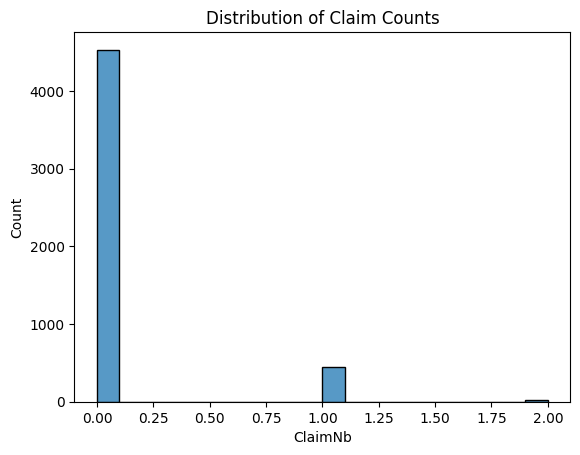

Average annual claim rate: 0.13586871637257633


In [4]:
#Info and summary
print(df.info())
print(df.describe())

#Distribution of number of claims
sns.histplot(df['ClaimNb'],bins=20,kde=False)
plt.title("Distribution of Claim Counts")
plt.show()

#Compute average claim rate per policy-year
df['ClaimRate']=df['ClaimNb']/df['Exposure']
print("Average annual claim rate:",df['ClaimRate'].mean())


<h2>Fit a Poisson Regression

In [6]:
poisson_model=smf.glm(
    formula="ClaimNb ~ DrivAge + VehAge + VehPower + BonusMalus + C(VehGas) + C(Area)",
    data=df,
    family=sm.families.Poisson(),
    offset=np.log(df['Exposure'])
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4992
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1657.3
Date:                Fri, 19 Sep 2025   Deviance:                       2357.2
Time:                        07:25:56   Pearson chi2:                 5.12e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001289
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9335 

<h2>Check for Overdispersion

In [7]:
mean_claims=df['ClaimNb'].mean()
var_claims=df['ClaimNb'].var()
print("Mean claims:",mean_claims)
print("Variance of claims:",var_claims)

Mean claims: 0.0992
Variance of claims: 0.0993792358471639


<h2>Fit a Negative Binomial Model
<h3>Negative Binomial is a generalization of Posiion that handles overdispersion

In [8]:
negbin_model=smf.glm(
    formula="ClaimNb ~ DrivAge + VehAge + VehPower + BonusMalus + C(VehGas) + C(Area)",
    data=df,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df['Exposure'])
).fit()

print(negbin_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4992
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1664.0
Date:                Fri, 19 Sep 2025   Deviance:                       1996.0
Time:                        07:31:49   Pearson chi2:                 4.66e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.001157
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9274 

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<h2>Estimate λ (Average Claim Rate) and 95% CI

In [9]:
lambda_hat = df['ClaimRate'].mean()
n = df.shape[0]
se = np.sqrt(lambda_hat / n)  # standard error

ci_lower = lambda_hat - 1.96 * se
ci_upper = lambda_hat + 1.96 * se

print(f"λ estimate = {lambda_hat:.4f}")
print(f"95% CI for λ = [{ci_lower:.4f}, {ci_upper:.4f}]")


λ estimate = 0.1359
95% CI for λ = [0.1257, 0.1461]


<h2>Goodness-of-Fit Test (Chi-square)


In [12]:
# Observed counts
obs_counts = df['ClaimNb'].value_counts().sort_index()

# Define bins (0 .. max observed, plus one "tail" bin)
max_obs = obs_counts.index.max()
k_values = np.arange(0, max_obs+1)

# Observed aligned
obs = obs_counts.reindex(k_values, fill_value=0).values

# Add observed tail (anything above max_obs)
obs_tail = (df['ClaimNb'] > max_obs).sum()
obs = np.append(obs, obs_tail)

# Expected counts
expected = len(df) * poisson.pmf(k_values, mu=lambda_hat)
expected_tail = len(df) * (1 - poisson.cdf(max_obs, mu=lambda_hat))
expected = np.append(expected, expected_tail)

# Chi-square test
chi2_stat, p_val = chisquare(f_obs=obs, f_exp=expected)

print(f"Chi² statistic = {chi2_stat:.4f}, p-value = {p_val:.4f}")


Chi² statistic = 50.3241, p-value = 0.0000


<h2>Visualizing Model Fit

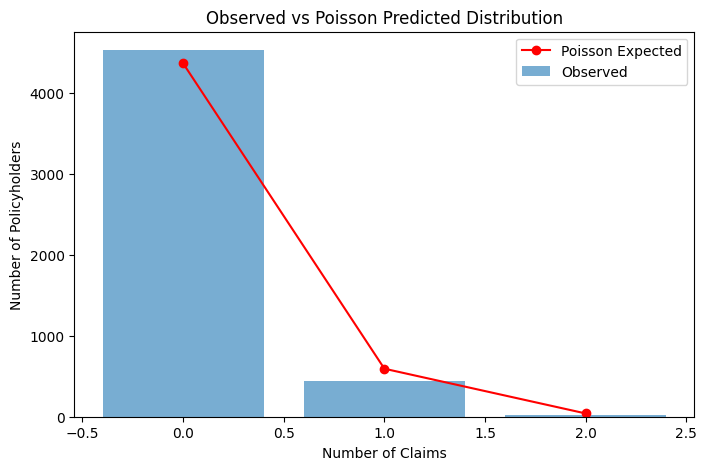

In [13]:
from scipy.stats import nbinom

# Observed distribution
obs_counts = df['ClaimNb'].value_counts().sort_index()

# Expected under Poisson with λ_hat
max_claims = obs_counts.index.max()
k_values = np.arange(0, max_claims+1)
poisson_probs = poisson.pmf(k_values, mu=lambda_hat)
poisson_expected = len(df) * poisson_probs

# Plot
plt.figure(figsize=(8,5))
plt.bar(obs_counts.index, obs_counts.values, alpha=0.6, label="Observed")
plt.plot(k_values, poisson_expected, "o-", color="red", label="Poisson Expected")
plt.xlabel("Number of Claims")
plt.ylabel("Number of Policyholders")
plt.title("Observed vs Poisson Predicted Distribution")
plt.legend()
plt.show()


<h2>Observed vs Negative Binomial Predicted Distribution

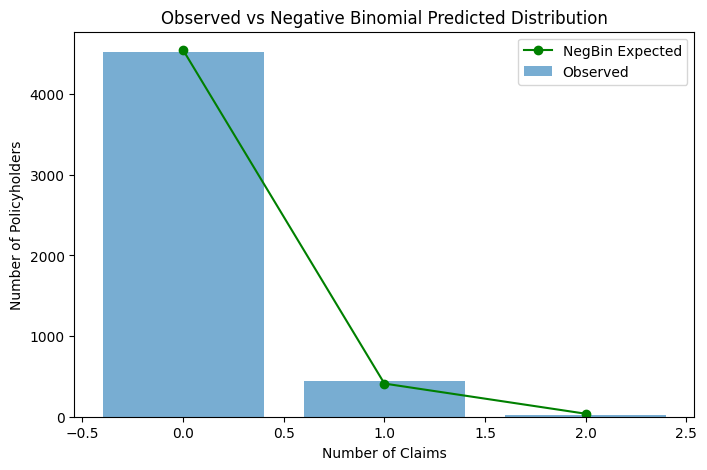

In [14]:
# Extract fitted mean claim rate (mu) and dispersion (alpha) from NegBin model
mu = negbin_model.mu.mean()
alpha = negbin_model.scale  # variance inflation parameter

# Negative Binomial parameters
# variance = mu + alpha * mu^2
# Using method-of-moments approximation
p = mu / (mu + alpha * mu**2)
r = mu * p / (1-p) if p < 1 else 1  # safeguard

nbinom_probs = nbinom.pmf(k_values, r, p)
nbinom_expected = len(df) * nbinom_probs

# Plot
plt.figure(figsize=(8,5))
plt.bar(obs_counts.index, obs_counts.values, alpha=0.6, label="Observed")
plt.plot(k_values, nbinom_expected, "o-", color="green", label="NegBin Expected")
plt.xlabel("Number of Claims")
plt.ylabel("Number of Policyholders")
plt.title("Observed vs Negative Binomial Predicted Distribution")
plt.legend()
plt.show()


<h2>Residual Plot for Model Fit

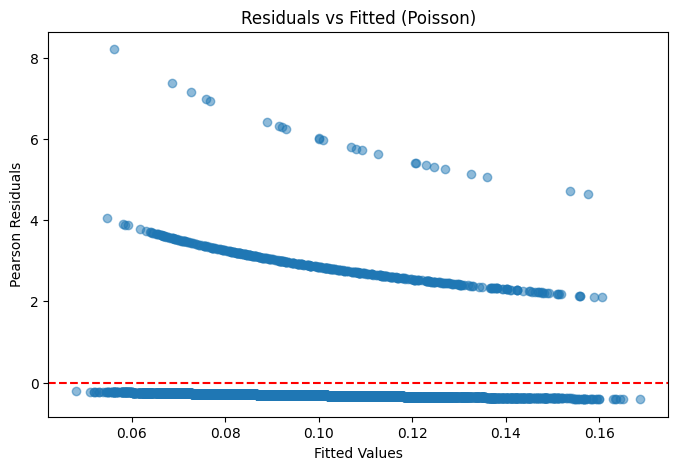

In [15]:
# Pearson residuals for Poisson
resid_pearson = poisson_model.resid_pearson

plt.figure(figsize=(8,5))
plt.scatter(poisson_model.fittedvalues, resid_pearson, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Residuals vs Fitted (Poisson)")
plt.show()
